# 02 — Exploratory Analysis: Rolling Correlations & Crisis Heatmaps

**Goal**: Compute rolling 60-day correlations between all asset pairs (crypto + TradFi) and visualize correlation heatmaps for each crisis event.

**Key questions**:
- Do crypto-TradFi correlations increase during crises (contagion)?
- Are there structural breaks in correlation regimes?
- Which asset pairs show the strongest co-movement?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'figure.dpi': 100,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

DATA_DIR = Path('..') / 'data'

## 1. Load Data

In [2]:
# Load log returns and events
returns = pd.read_csv(DATA_DIR / 'returns.csv', index_col='Date', parse_dates=True)
events = pd.read_csv(DATA_DIR / 'events.csv', index_col=0, parse_dates=['start', 'end'])

# Separate asset groups for labeling
TRADFI = ['Gold', 'NASDAQ 100', 'S&P 500', 'US Treasury 20Y+', 'US Dollar Index', 'VIX']
CRYPTO = ['Aave (DeFi proxy)', 'BNB', 'Bitcoin', 'Ethereum', 'Solana']

# Keep only columns that actually exist in the data
TRADFI = [c for c in TRADFI if c in returns.columns]
CRYPTO = [c for c in CRYPTO if c in returns.columns]
ALL_ASSETS = TRADFI + CRYPTO

print(f'Date range: {returns.index[0].date()} to {returns.index[-1].date()}')
print(f'Trading days: {len(returns)}')
print(f'TradFi assets ({len(TRADFI)}): {TRADFI}')
print(f'Crypto assets ({len(CRYPTO)}): {CRYPTO}')
print(f'\nMissing values per asset:')
print(returns[ALL_ASSETS].isna().sum())
print(f'\nEvents:')
display(events)

Date range: 2019-01-03 to 2025-01-31
Trading days: 1529
TradFi assets (6): ['Gold', 'NASDAQ 100', 'S&P 500', 'US Treasury 20Y+', 'US Dollar Index', 'VIX']
Crypto assets (5): ['Aave (DeFi proxy)', 'BNB', 'Bitcoin', 'Ethereum', 'Solana']

Missing values per asset:
Gold                   0
NASDAQ 100             0
S&P 500                0
US Treasury 20Y+       0
US Dollar Index        0
VIX                    0
Aave (DeFi proxy)    442
BNB                    0
Bitcoin                0
Ethereum               0
Solana               321
dtype: int64

Events:


,start,end
COVID Crash,2020-02-20,2020-04-15
China Crypto Ban,2021-05-10,2021-06-30
Luna/Terra Collapse,2022-05-01,2022-06-15
FTX Collapse,2022-11-01,2022-12-15
SVB Crisis,2023-03-01,2023-04-15
BTC ETF Approval,2024-01-01,2024-02-15


## 2. Rolling Correlations (60-day window)

We compute pairwise rolling correlations using a 60-trading-day window (~3 calendar months). This window is standard in financial contagion literature — short enough to capture regime changes, long enough for statistical reliability.

In [3]:
def compute_rolling_correlations(returns_df, window=60):
    """
    Compute pairwise rolling correlations for all asset pairs.
    
    Parameters
    ----------
    returns_df : pd.DataFrame
        DataFrame of log returns, columns = assets, index = dates.
    window : int
        Rolling window size in trading days.
    
    Returns
    -------
    rolling_corr : dict
        Dict of {(asset_i, asset_j): pd.Series} with rolling correlation.
        Only upper triangle pairs (i < j) to avoid duplicates.
    """
    assets = returns_df.columns.tolist()
    rolling_corr = {}
    
    for i in range(len(assets)):
        for j in range(i + 1, len(assets)):
            pair = (assets[i], assets[j])
            rolling_corr[pair] = returns_df[assets[i]].rolling(window).corr(returns_df[assets[j]])
    
    return rolling_corr


# Compute rolling correlations
WINDOW = 60
rolling_corr = compute_rolling_correlations(returns[ALL_ASSETS], window=WINDOW)

print(f'Computed {len(rolling_corr)} pairwise rolling correlations (window={WINDOW} days)')

Computed 55 pairwise rolling correlations (window=60 days)


### 2.1 Key Cross-Market Pairs: BTC vs TradFi

The most important correlations for the contagion thesis: Bitcoin against each traditional asset. Shaded regions = crisis events.

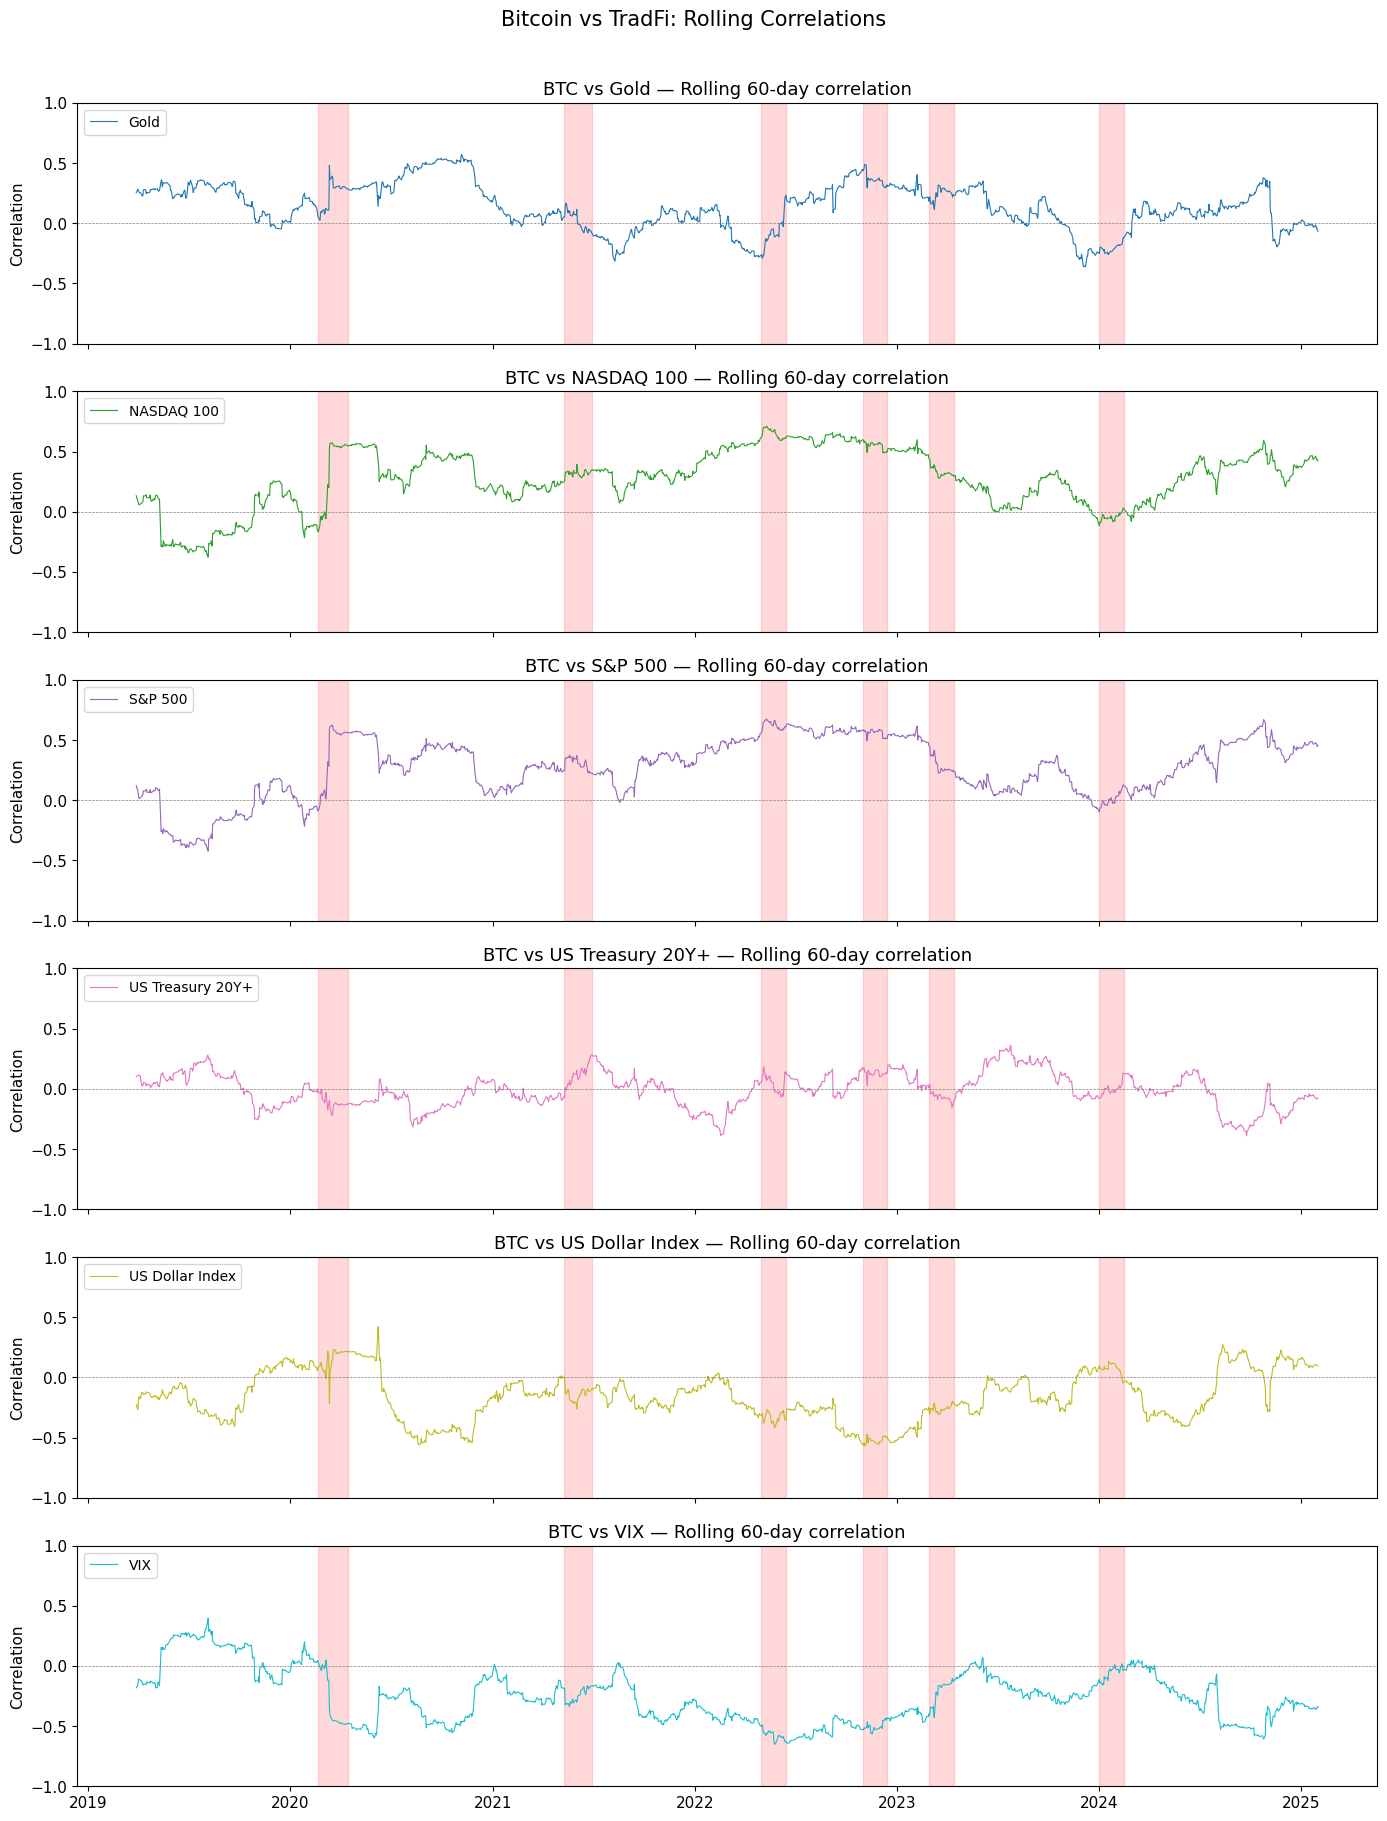

In [4]:
def plot_rolling_corr_vs_btc(rolling_corr, events, tradfi_assets):
    """
    Plot rolling correlation of Bitcoin vs each TradFi asset,
    with crisis event windows shaded.
    """
    # Select BTC-TradFi pairs
    btc_pairs = []
    for asset in tradfi_assets:
        # The pair could be stored as (asset, Bitcoin) or (Bitcoin, asset)
        if ('Bitcoin', asset) in rolling_corr:
            btc_pairs.append(('Bitcoin', asset))
        elif (asset, 'Bitcoin') in rolling_corr:
            btc_pairs.append((asset, 'Bitcoin'))
    
    fig, axes = plt.subplots(len(btc_pairs), 1, figsize=(14, 3 * len(btc_pairs)), sharex=True)
    if len(btc_pairs) == 1:
        axes = [axes]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(btc_pairs)))
    
    for ax, pair, color in zip(axes, btc_pairs, colors):
        series = rolling_corr[pair].dropna()
        other_asset = pair[0] if pair[1] == 'Bitcoin' else pair[1]
        
        ax.plot(series.index, series.values, color=color, linewidth=0.8, label=other_asset)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
        
        # Shade crisis events
        for event_name, row in events.iterrows():
            ax.axvspan(row['start'], row['end'], alpha=0.15, color='red')
        
        ax.set_ylabel('Correlation')
        ax.set_ylim(-1, 1)
        ax.legend(loc='upper left', fontsize=10)
        ax.set_title(f'BTC vs {other_asset} — Rolling {WINDOW}-day correlation')
    
    axes[-1].xaxis.set_major_locator(mdates.YearLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    fig.suptitle('Bitcoin vs TradFi: Rolling Correlations', fontsize=15, y=1.01)
    plt.tight_layout()
    plt.show()


plot_rolling_corr_vs_btc(rolling_corr, events, TRADFI)

### 2.2 Average Cross-Market Correlation Over Time

Aggregate measure: mean absolute correlation between crypto and TradFi assets. Rising trend = markets becoming more interconnected.

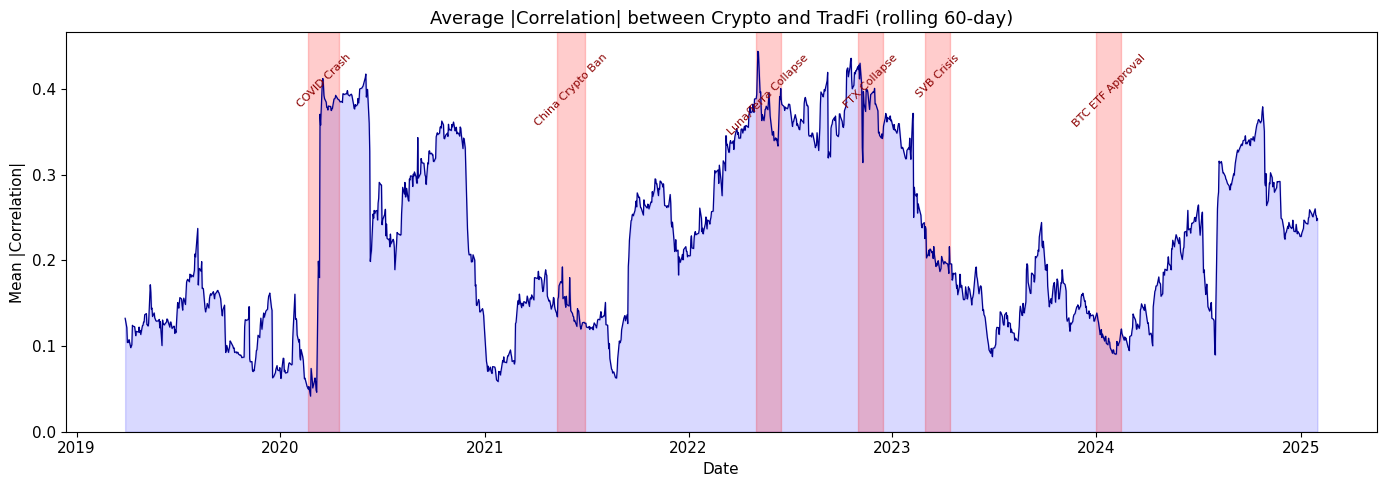

In [5]:
def compute_avg_cross_correlation(rolling_corr, tradfi, crypto):
    """
    Compute the average absolute cross-market correlation over time.
    
    Only includes pairs where one asset is TradFi and the other is Crypto.
    Uses absolute correlation because negative correlation also = dependence.
    """
    cross_pairs = []
    for pair, series in rolling_corr.items():
        a, b = pair
        is_cross = (a in tradfi and b in crypto) or (a in crypto and b in tradfi)
        if is_cross:
            cross_pairs.append(series.abs())
    
    # Stack into DataFrame and compute mean across pairs for each date
    cross_df = pd.concat(cross_pairs, axis=1)
    avg_corr = cross_df.mean(axis=1)
    
    return avg_corr


avg_cross_corr = compute_avg_cross_correlation(rolling_corr, TRADFI, CRYPTO)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(avg_cross_corr.index, avg_cross_corr.values, color='darkblue', linewidth=0.9)
ax.fill_between(avg_cross_corr.index, 0, avg_cross_corr.values, alpha=0.15, color='blue')

# Shade and label crisis events
for event_name, row in events.iterrows():
    ax.axvspan(row['start'], row['end'], alpha=0.2, color='red')
    mid_date = row['start'] + (row['end'] - row['start']) / 2
    ax.text(mid_date, ax.get_ylim()[1] * 0.95, event_name,
            ha='center', va='top', fontsize=8, rotation=45, color='darkred')

ax.set_title(f'Average |Correlation| between Crypto and TradFi (rolling {WINDOW}-day)', fontsize=13)
ax.set_ylabel('Mean |Correlation|')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylim(0, None)
plt.tight_layout()
plt.show()

## 3. Crisis Event Heatmaps

For each event window, compute the correlation matrix of log returns and display it as a heatmap. This shows which assets move together **during** each crisis.

**Note on VIX**: VIX is already a volatility measure (not a price), so its correlations with equity returns should be negative (VIX rises when stocks fall). A strong negative correlation here is expected, not anomalous.

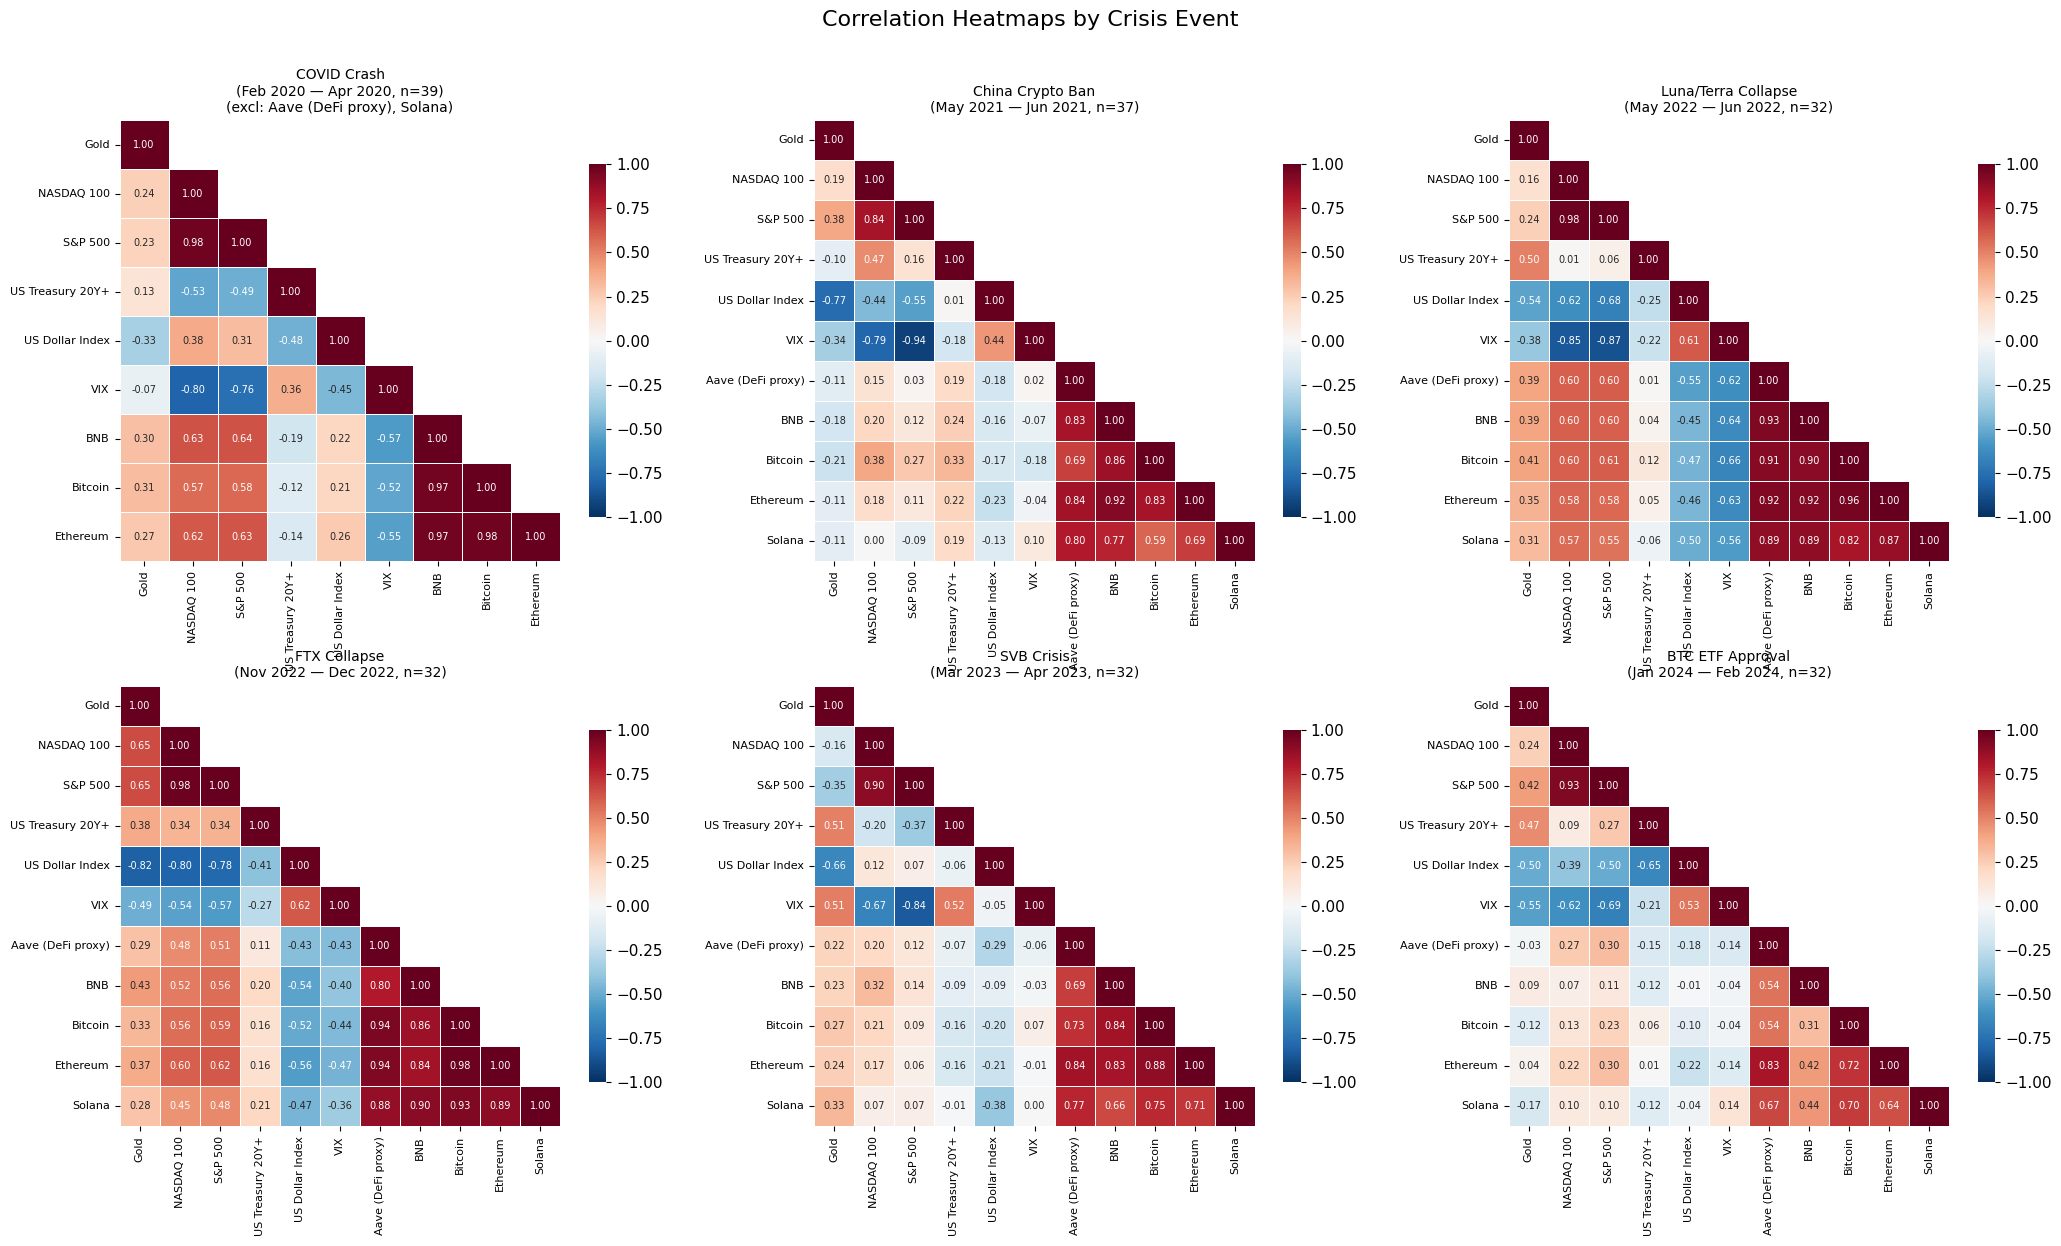

In [6]:
def plot_crisis_heatmaps(returns_df, events, assets, figsize_per_map=(7, 6)):
    """
    Plot a correlation heatmap for each crisis event.
    
    Only includes assets that have sufficient data (>=10 observations)
    in each event window. This handles cases like COVID where Aave/Solana
    didn't exist yet.
    
    Parameters
    ----------
    returns_df : pd.DataFrame
        Full returns DataFrame.
    events : pd.DataFrame
        Events with 'start' and 'end' columns.
    assets : list
        List of asset column names to include.
    """
    n_events = len(events)
    n_cols = 3
    n_rows = int(np.ceil(n_events / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize_per_map[0] * n_cols, figsize_per_map[1] * n_rows))
    axes = axes.flatten()
    
    for idx, (event_name, row) in enumerate(events.iterrows()):
        ax = axes[idx]
        
        # Extract returns for this event window
        event_returns = returns_df.loc[row['start']:row['end'], assets]
        
        # Filter to assets with enough observations (>=10) for reliable correlation
        valid_counts = event_returns.count()
        valid_assets = valid_counts[valid_counts >= 10].index.tolist()
        event_returns = event_returns[valid_assets]
        n_obs = len(event_returns.dropna(how='all'))
        
        # Note which assets were excluded
        excluded = set(assets) - set(valid_assets)
        
        # Compute correlation matrix (pairwise complete observations)
        corr_matrix = event_returns.corr()
        
        # Create mask for upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        
        # Plot heatmap
        sns.heatmap(
            corr_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            ax=ax,
            annot_kws={'size': 7}
        )
        
        title = f'{event_name}\n({row["start"].strftime("%b %Y")} — {row["end"].strftime("%b %Y")}, n={n_obs})'
        if excluded:
            title += f'\n(excl: {", ".join(sorted(excluded))})'
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', labelsize=8)
    
    # Hide any unused subplots
    for idx in range(n_events, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle('Correlation Heatmaps by Crisis Event', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


plot_crisis_heatmaps(returns, events, ALL_ASSETS)

### 3.1 Baseline Comparison: Full-Period Correlation

To contextualize the crisis heatmaps, here's the correlation matrix over the full sample period.

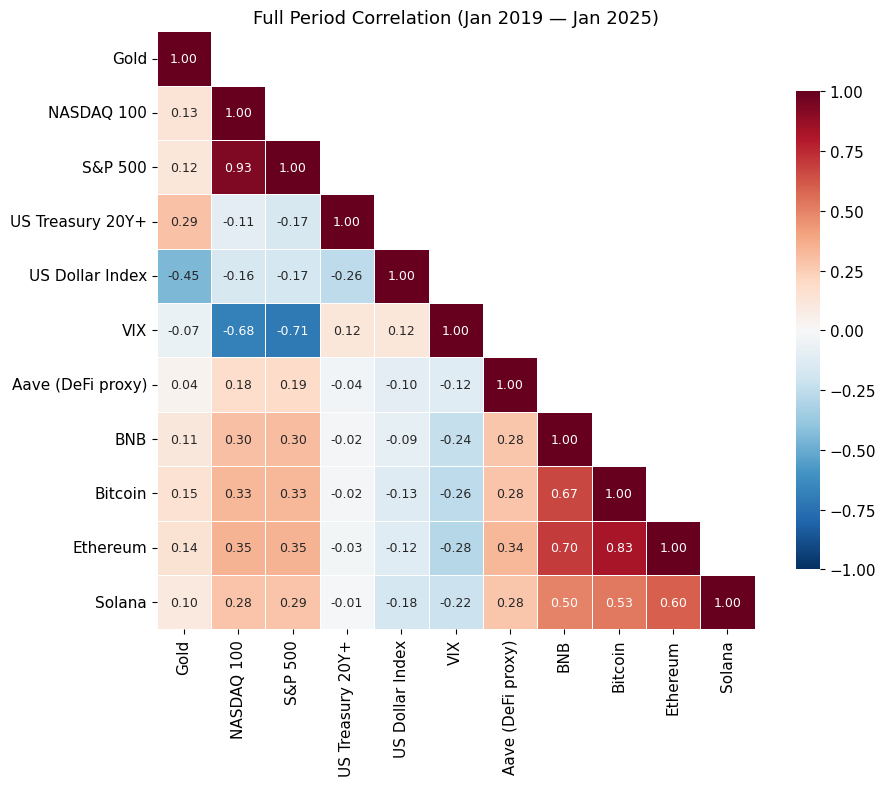

In [7]:
# Full-period correlation for baseline comparison
full_corr = returns[ALL_ASSETS].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(full_corr, dtype=bool), k=1)

sns.heatmap(
    full_corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    ax=ax,
    annot_kws={'size': 9}
)

ax.set_title(f'Full Period Correlation ({returns.index[0].strftime("%b %Y")} — {returns.index[-1].strftime("%b %Y")})',
             fontsize=13)
plt.tight_layout()
plt.show()

### 3.2 Crisis vs Baseline: Correlation Shift

How much does each crisis shift correlations relative to the full-period baseline? Positive values = correlation increases during crisis (potential contagion signal).

,mean_|cross_corr|,baseline,shift,n_pairs
event,,,,
COVID Crash,0.408,0.178,0.230,18
China Crypto Ban,0.157,0.178,-0.020,30
Luna/Terra Collapse,0.452,0.178,0.274,30
FTX Collapse,0.416,0.178,0.238,30
SVB Crisis,0.152,0.178,-0.025,30
BTC ETF Approval,0.126,0.178,-0.052,30


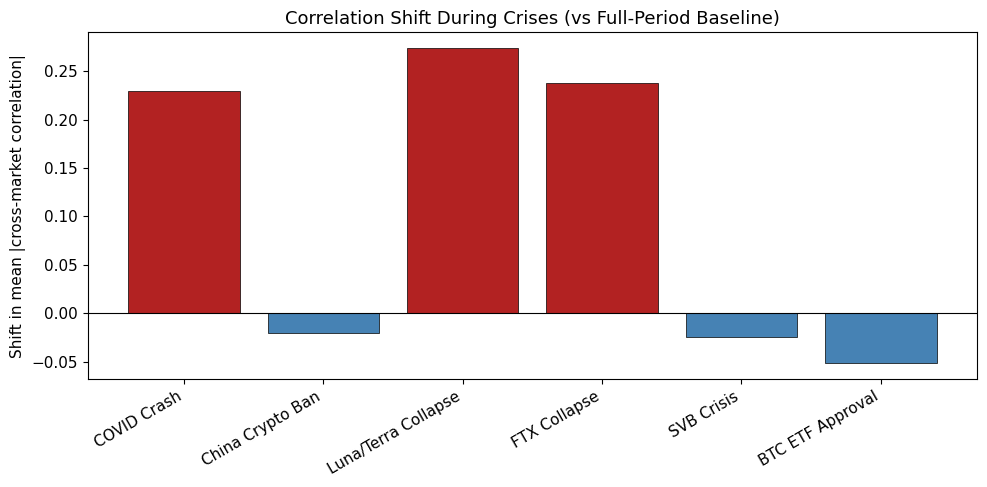

In [8]:
def compute_correlation_shift(returns_df, events, assets, min_obs=10):
    """
    For each event, compute how much the cross-market correlation
    (crypto-TradFi pairs) shifts relative to the full-period baseline.
    
    Only includes pairs where both assets have >= min_obs observations
    in the event window. Uses nanmean to handle any remaining NaNs.
    
    Returns a DataFrame: rows = events, columns = metrics.
    """
    tradfi = [a for a in assets if a in TRADFI]
    crypto = [a for a in assets if a in CRYPTO]
    
    # Baseline: full-period cross-market mean absolute correlation
    full_corr = returns_df[assets].corr()
    baseline_vals = []
    for t in tradfi:
        for c in crypto:
            val = full_corr.loc[t, c]
            if not np.isnan(val):
                baseline_vals.append(abs(val))
    baseline = np.mean(baseline_vals)
    
    rows = []
    for event_name, row in events.iterrows():
        event_returns = returns_df.loc[row['start']:row['end'], assets]
        
        # Only keep assets with enough data
        valid_counts = event_returns.count()
        valid_assets = valid_counts[valid_counts >= min_obs].index.tolist()
        event_returns = event_returns[valid_assets]
        event_corr = event_returns.corr()
        
        cross_vals = []
        for t in tradfi:
            for c in crypto:
                if t in event_corr.columns and c in event_corr.columns:
                    val = event_corr.loc[t, c]
                    if not np.isnan(val):
                        cross_vals.append(abs(val))
        
        n_pairs = len(cross_vals)
        mean_cross = np.mean(cross_vals) if cross_vals else np.nan
        shift = mean_cross - baseline if not np.isnan(mean_cross) else np.nan
        
        rows.append({
            'event': event_name,
            'mean_|cross_corr|': round(mean_cross, 3) if not np.isnan(mean_cross) else np.nan,
            'baseline': round(baseline, 3),
            'shift': round(shift, 3) if not np.isnan(shift) else np.nan,
            'n_pairs': n_pairs
        })
    
    return pd.DataFrame(rows).set_index('event')


shift_df = compute_correlation_shift(returns, events, ALL_ASSETS)
display(shift_df)

# Bar chart of shifts
fig, ax = plt.subplots(figsize=(10, 5))
plot_data = shift_df.dropna(subset=['shift'])
colors = ['firebrick' if v > 0 else 'steelblue' for v in plot_data['shift']]
ax.bar(plot_data.index, plot_data['shift'], color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylabel('Shift in mean |cross-market correlation|')
ax.set_title('Correlation Shift During Crises (vs Full-Period Baseline)', fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()